In [44]:
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.models import Model, Sequential
from keras.layers import Concatenate, Dense, Input, Conv2D, Lambda, MaxPool2D, Flatten
from keras.optimizers import Adam
from PIL import Image
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import cv2
from matplotlib import pyplot as plt
import random
random.seed = 7
from keras import backend as K


from deep_tools.training_callbacks import *
np.random.seed(7)

In [45]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
#     print ("aaaaaaaaaaaaaaa", y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [46]:
def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)

In [47]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [51]:
# input_before = Input(shape=(128, 128, 3))
# input_after = Input(shape=(128, 128, 3))
# mobile = Dense(1024, activation="relu")
# before_feature = mobile(input_before)
# after_feature = mobile(input_after)
# # # after_feature = Dense(1024, activation="relu")(after_feature)
# # L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# # distance = L1_layer([before_feature, after_feature])
# distance = Lambda(euclidean_distance,
#                   output_shape=eucl_dist_output_shape)([before_feature, after_feature])

# # layer = Concatenate()([before_feature, after_feature])
# # layer = Dense(1024, activation="relu")(layer)
# # layer = Dense(1024, activation="relu")(layer)
# # layer = Dense(1, activation="sigmoid")(distance)
# model = Model([input_before, input_after], distance)

In [49]:
input_before = Input(shape=(128, 128, 3))
input_after = Input(shape=(128, 128, 3))
mobile = MobileNet(input_shape=(128,128,3), weights="imagenet")
mobile = Sequential(layers=mobile.layers[2:-5])
before_feature = mobile(input_before)
after_feature = mobile(input_after)
# # before_feature = Dense(1024, activation="relu")(before_feature)
# # after_feature = Dense(1024, activation="relu")(after_feature)
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# distance = L1_layer([before_feature, after_feature])
distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([before_feature, after_feature])

# layer = Concatenate()([before_feature, after_feature])
# layer = Dense(1024, activation="relu")(layer)
# layer = Dense(1024, activation="relu")(layer)
# layer = Dense(1, activation="sigmoid")(distance)
model = Model([input_before, input_after], distance)

In [52]:
model.compile(loss=contrastive_loss, optimizer=Adam(), metrics=[acc])

In [53]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               multiple                  864       
_________________________________________________________________
conv1_bn (BatchNormalization multiple                  128       
_________________________________________________________________
conv1_relu (ReLU)            multiple                  0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  multiple                  288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza multiple                  128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        multiple                  0         
_________________________________________________________________
conv_pw_1 (Conv2D)           multiple                  2048      
__________

In [54]:
images_path = "/home/wc-gpu/storage4tb/session_data_thesis/similar_boxes"

In [41]:
images_add = []
images_move = []
total = len(os.listdir(images_path))
c = 0
print (total)

for imp in os.listdir(images_path):
    data = int(imp.split("-")[0]), cv2.imread(os.path.join(images_path, imp))
    if "add" in imp:
        images_add.append(data)
    else:
        images_move.append(data)
    if not c%100:
        print (c, total, str(c/total)[:6], end="                                                                 \r")
    c+=1

38096


In [ ]:
len(images_add)/2

In [ ]:
len(images_move)/2

In [55]:
images_add.sort(key=lambda a: a[0])
images_move.sort(key=lambda a: a[0])

In [56]:
first = [cv2.resize(images_add[i][1], (128, 128)) for i in range(0, len(images_add), 2)]

In [57]:
second = [cv2.resize(images_add[i][1], (128, 128)) for i in range(1, len(images_add), 2)]

In [58]:
add_rand = list(range(len(first)))
random.shuffle(add_rand)
add_rand = add_rand[:2000]

In [59]:
first = [first[i] for i in add_rand]
second = [second[i] for i in add_rand]

In [60]:
first += [cv2.resize(images_move[i][1], (128, 128)) for i in range(0, len(images_move), 2)]
second += [cv2.resize(images_move[i][1], (128, 128)) for i in range(1, len(images_move), 2)]

In [61]:
first = np.stack(first).astype("float32")

In [62]:
second = np.stack(second).astype("float32")

In [ ]:
len(first)

In [ ]:
# -86 same diff [0.99766123]1
# -84 same diff [0.99663854]2
# -62 same diff [0.5117964]3
# -57 same diff [0.99960846]
# -55 same diff [0.996974]
# -50 same diff [0.7908154]
# -48 same diff [0.99994576]
# -46 same diff [0.6441729]
# -31 same diff [0.99958986]
# -21 same diff [0.88893837]


# 8 same diff [0.02218271]
# 19 same diff [0.42524236]
# 25 same diff [0.10976616]
# 28 same diff [0.00051955]2
# 37 same diff [0.4258078]
# 49 same diff [0.35775208]3
# 50 same diff a0.06384885]
# 53 same diff [0.25450426]
# 63 same diff [0.04156434]
# 67 same diff [0.0015482]
# 75 same diff [0.03109886]
# 78 same diff [0.4863313]
# 88 same diff [0.00188515]
# 89 same diff [0.46252853]1
# 91 same diff [0.00582761]

In [ ]:
# 1 same diff [0.55520195]
# 3 same diff [0.92830646]
# 25 same diff [0.738778]
# 41 same diff [0.9809709]
# 53 same diff [0.91135925]
# 56 same diff [0.8680242]
# 87 same diff [0.88560057]
​

In [ ]:
plt.imshow(first_negative[25])

In [ ]:
plt.imshow(second[25])

In [ ]:
datagen = ImageDataGenerator(
            rotation_range=45,
            rescale=1./255.,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest',
            zca_whitening=True)

In [ ]:
first.shape

In [ ]:
first = datagen.flow(first, batch_size=len(first), shuffle=False).next()

In [ ]:
second = datagen.flow(first, batch_size=len(first), shuffle=False).next()

In [ ]:
plt.imshow(first[-2])

In [63]:
negative = np.zeros(first.shape[0])
positive = np.ones(first.shape[0])

In [64]:
Y = np.dstack([positive, negative]).flatten()

In [65]:
second_negative = np.copy(second)

In [66]:
idx = np.arange(len(second_negative))
np.random.shuffle(idx)

In [67]:
second_negative = second_negative[idx]

In [68]:
X1 = []
X2 = []
for i in range(len(first)):
    X1.append(first[i])
    X2.append(second[i])
    X1.append(first[i])
    X2.append(second_negative[i])
X1 = np.array(X1)
X2 = np.array(X2)

In [69]:
# idx = np.arange(len(Y))
# np.random.shuffle(idx)

In [70]:
# X1 = X1[idx]
# X2 = X2[idx]
# Y = Y[idx]

In [71]:
spl = 600
X1test = X1[:spl]
X2test = X2[:spl]
Ytest = Y[:spl]
X1 = X1[spl:]
X2 = X2[spl:]
Y = Y[spl:]

In [27]:
len(Ytest)

600

In [28]:
len(Y)

5546

In [29]:
len(first)

3073

In [72]:
acc_callback = TrainingAccuracyPlotter()
loss_plotter = TrainingLossPlotter()
time_plotter = TimeLogCallback()


checkpoint = checkpoint_classification_callback(
    checkpoint_path="/home/wc-gpu/MasterThesis/models/research/object_detection/od_api_tf_my_notebooks/checkpoint_similar", 
    monitor='val_acc',
    save_best_only=True)
callbacks = [time_plotter, acc_callback, checkpoint]

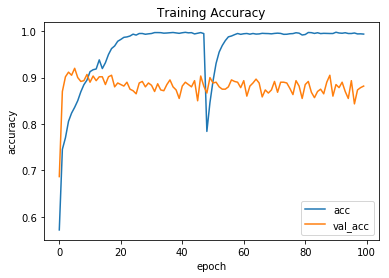


Epoch 00100: val_acc did not improve from 0.92000


In [73]:
hitsory = model.fit(x=[X1, X2],
    y=Y, 
    batch_size=32,
    epochs=100,
    verbose=1, 
    callbacks=callbacks,
    validation_data = [[X1test, X2test], Ytest],
#     validation_split=0.1, 
#     shuffle=True, 
    sample_weight=None, 
    initial_epoch=0)

In [ ]:
from keras.models import load_model
# model.load_weights("checkpoint_similar/2019-04-08weights-epoch94-val_acc0.85-val_loss0.13.hdf5")
model = load_model("checkpoint_similar/keep/2019-04-08weights-epoch26-val_acc0.83-val_loss0.79-vgg_sigmoid.hdf5")

In [ ]:
for i in range(100):
    a = model.predict([first[i:i+1], second_negative[i:i+1]])[0]
    if a > 0.5 and 0:
        print (i, "same", "diff", a)
    elif a < 0.5 and 1:
        print (i, "diff", "same", a)

In [ ]:
plt.imshow(first[1])

In [ ]:
plt.imshow(second[1])

In [ ]:
'''Trains a Siamese MLP on pairs of digits from the MNIST dataset.

It follows Hadsell-et-al.'06 [1] by computing the Euclidean distance on the
output of the shared network and by optimizing the contrastive loss (see paper
for more details).

# References

- Dimensionality Reduction by Learning an Invariant Mapping
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf

Gets to 97.2% test accuracy after 20 epochs.
2 seconds per epoch on a Titan X Maxwell GPU
'''
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K

num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

In [ ]:
tr_pairs.shape

In [ ]:
tr_y.shape

In [ ]:
tr_y[:10]